In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo21040_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo22010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo21050_sx1.fits'],
      dtype='<U67')

/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo21040_x1d.fits
G140M
[553.90546]


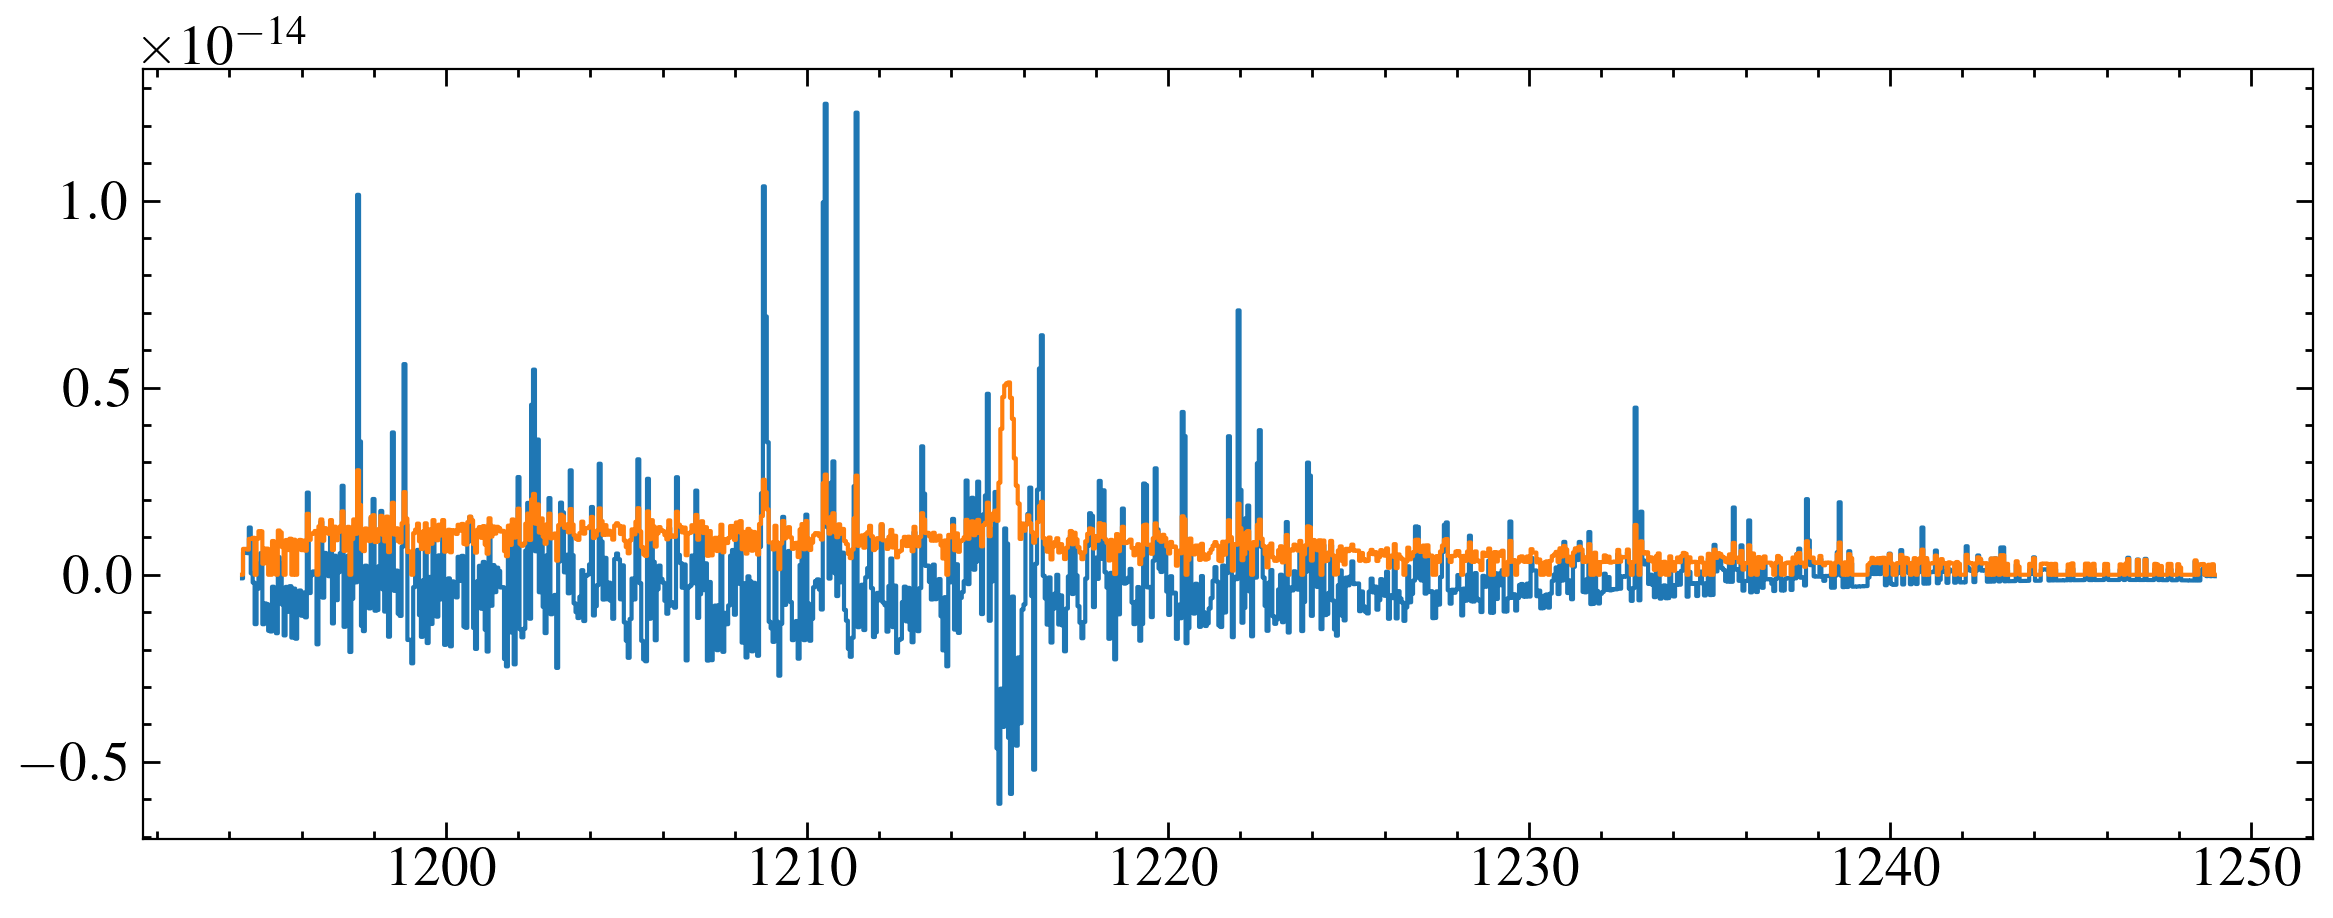

/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo22010_x1d.fits
G140L
[719.6955]


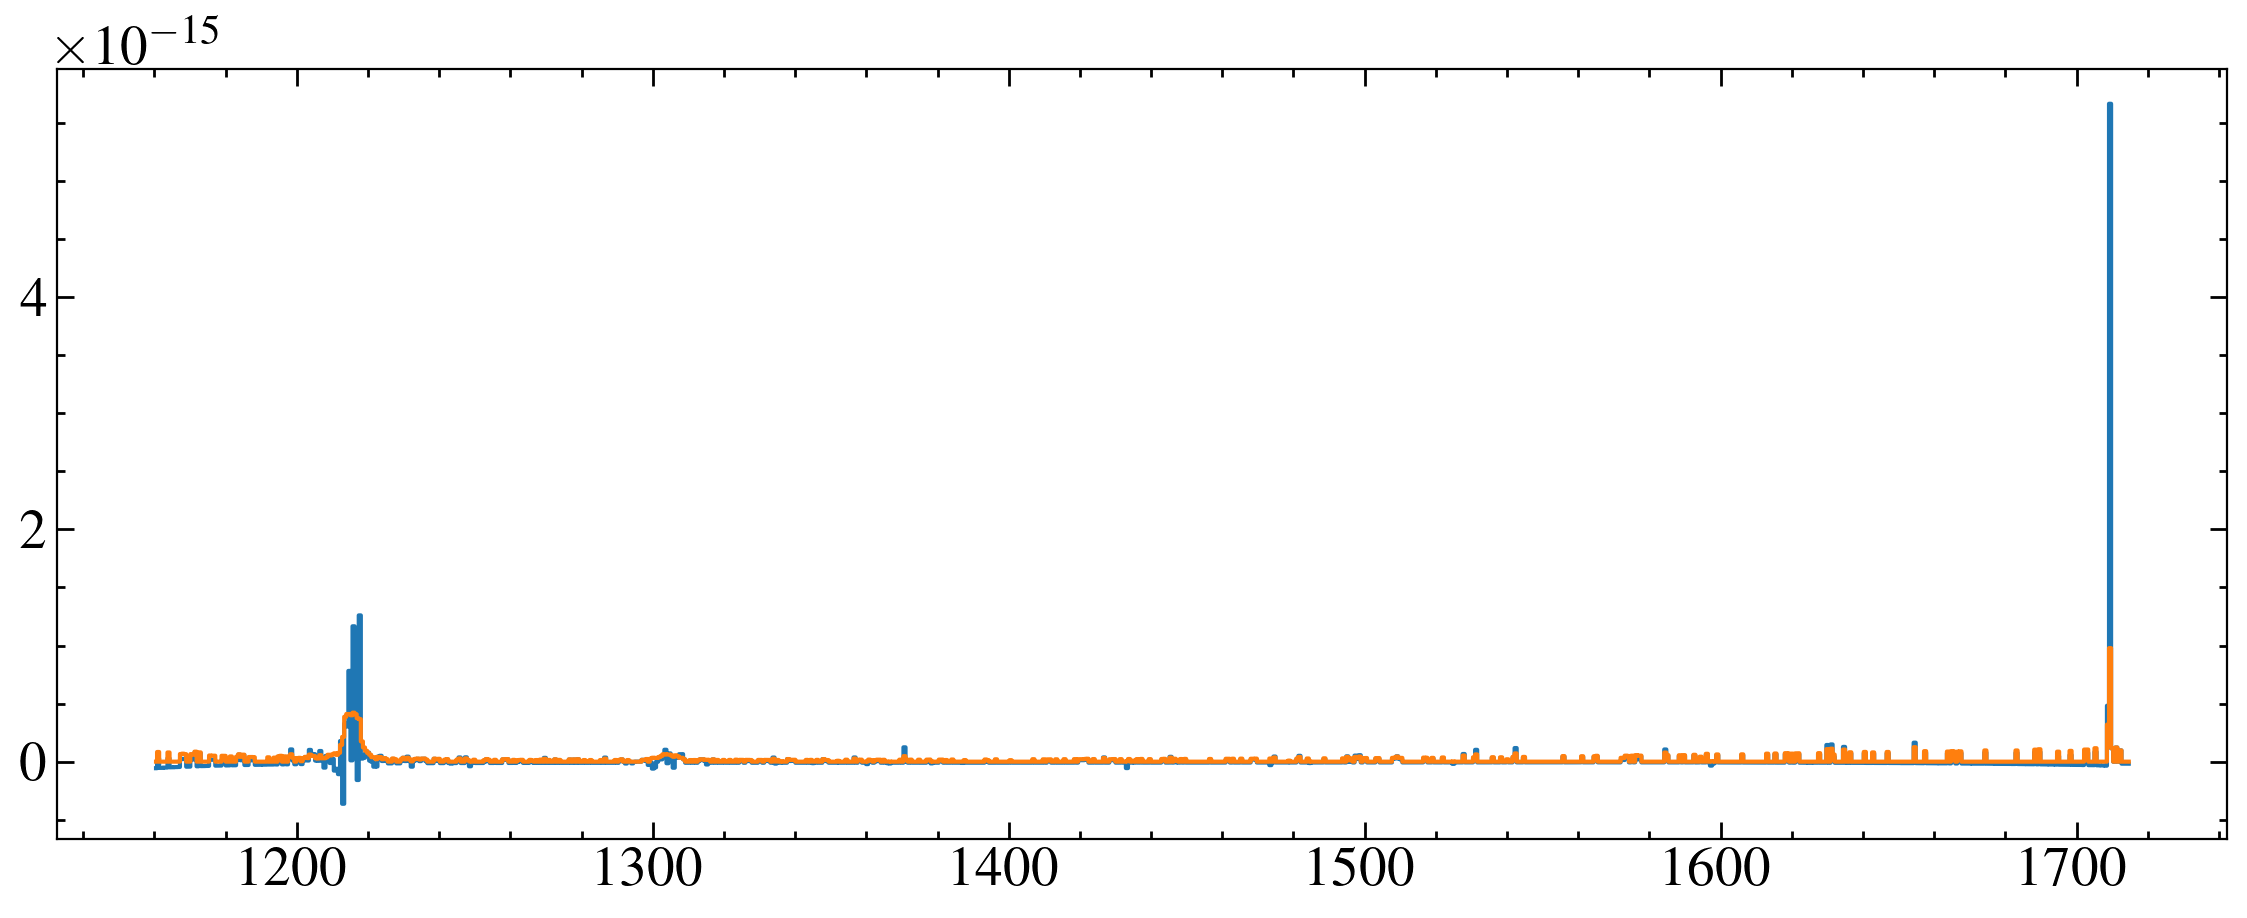

/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo21050_sx1.fits
G430L
[893.62823]


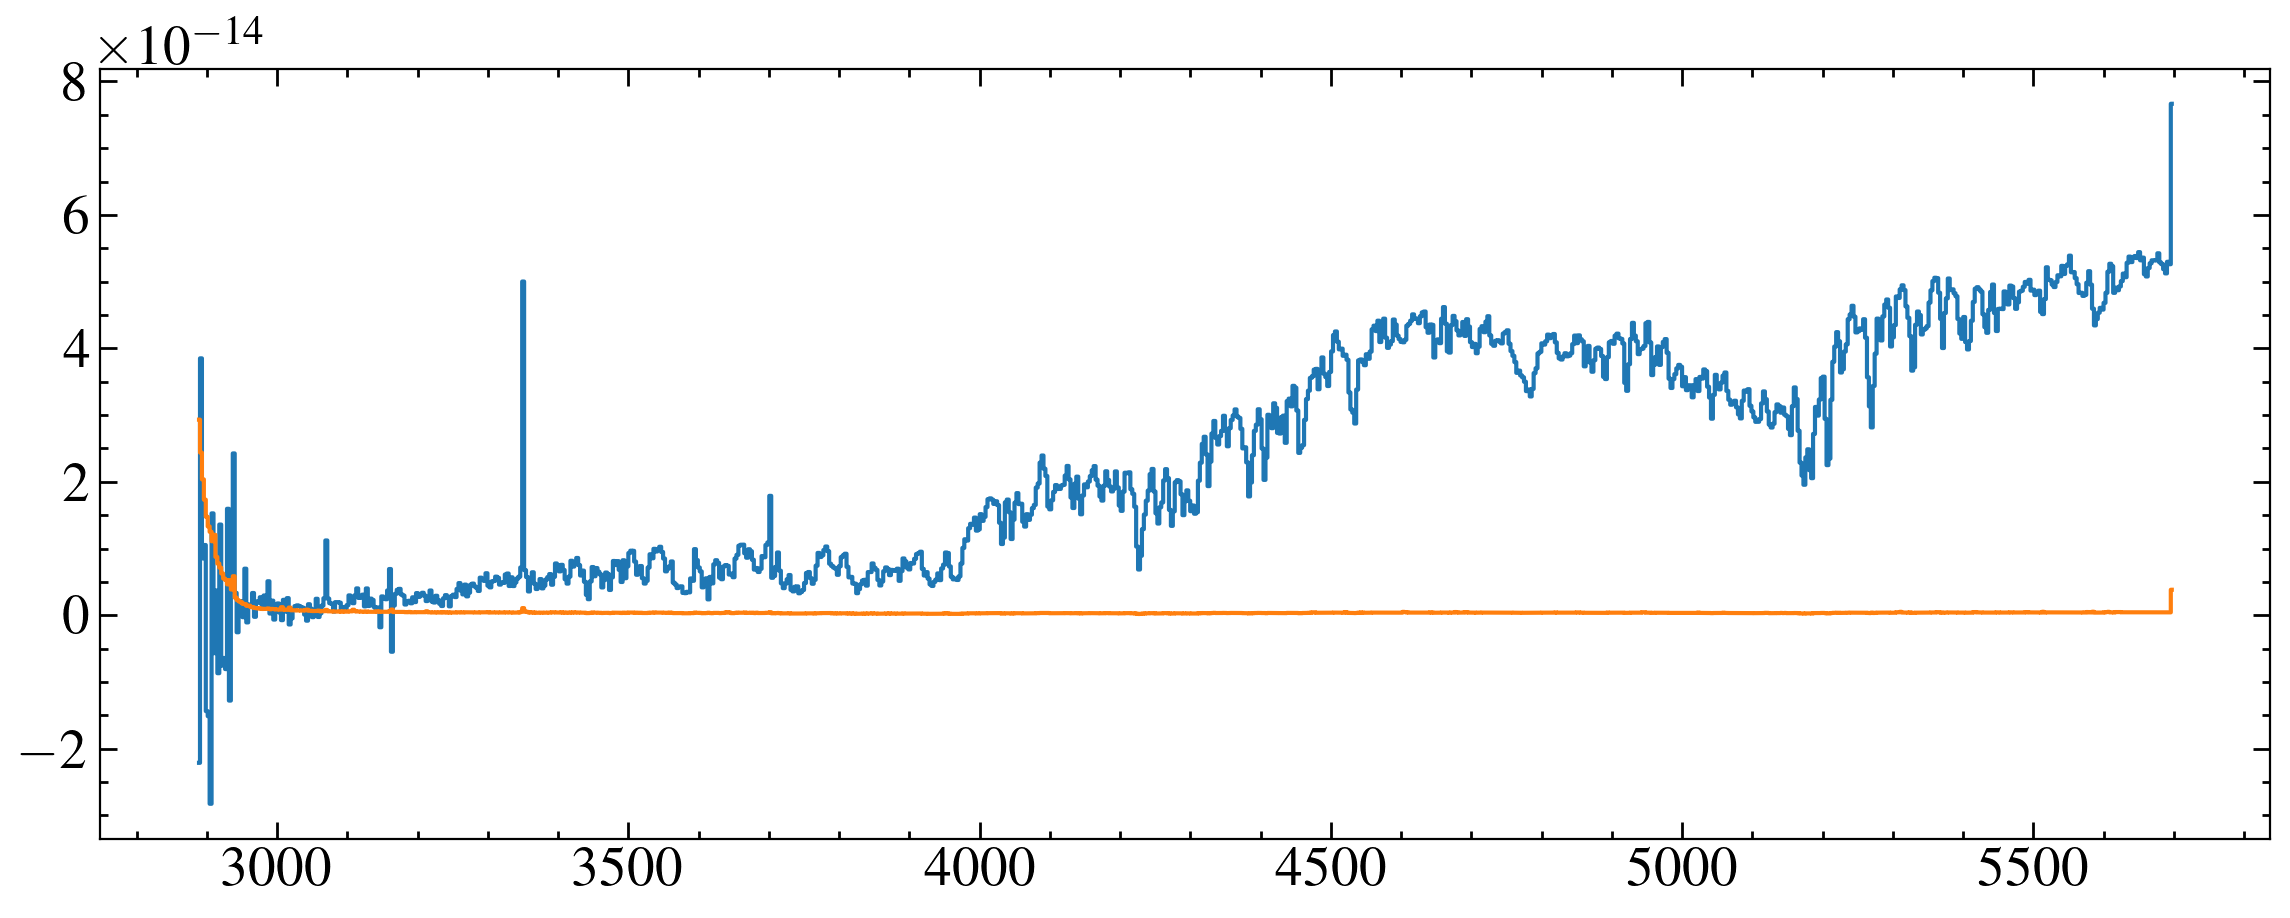

In [4]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.show()

    

Bad extraction on oeoo21040.

In [5]:
import stistools
os.environ['oref'] = path

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [6]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

In [65]:
for root in  ['oeoo21040']:
    flt = '{}/{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/toi-178/{}_new_x1d.fits'.format(rootname)
    a2center = get_a2center(410,181, tracegrid)
    print(a2center)
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/toi-178/{}_new.trl'.format(rootname), a2center=a2center, maxsrch=5)

183


179.89566


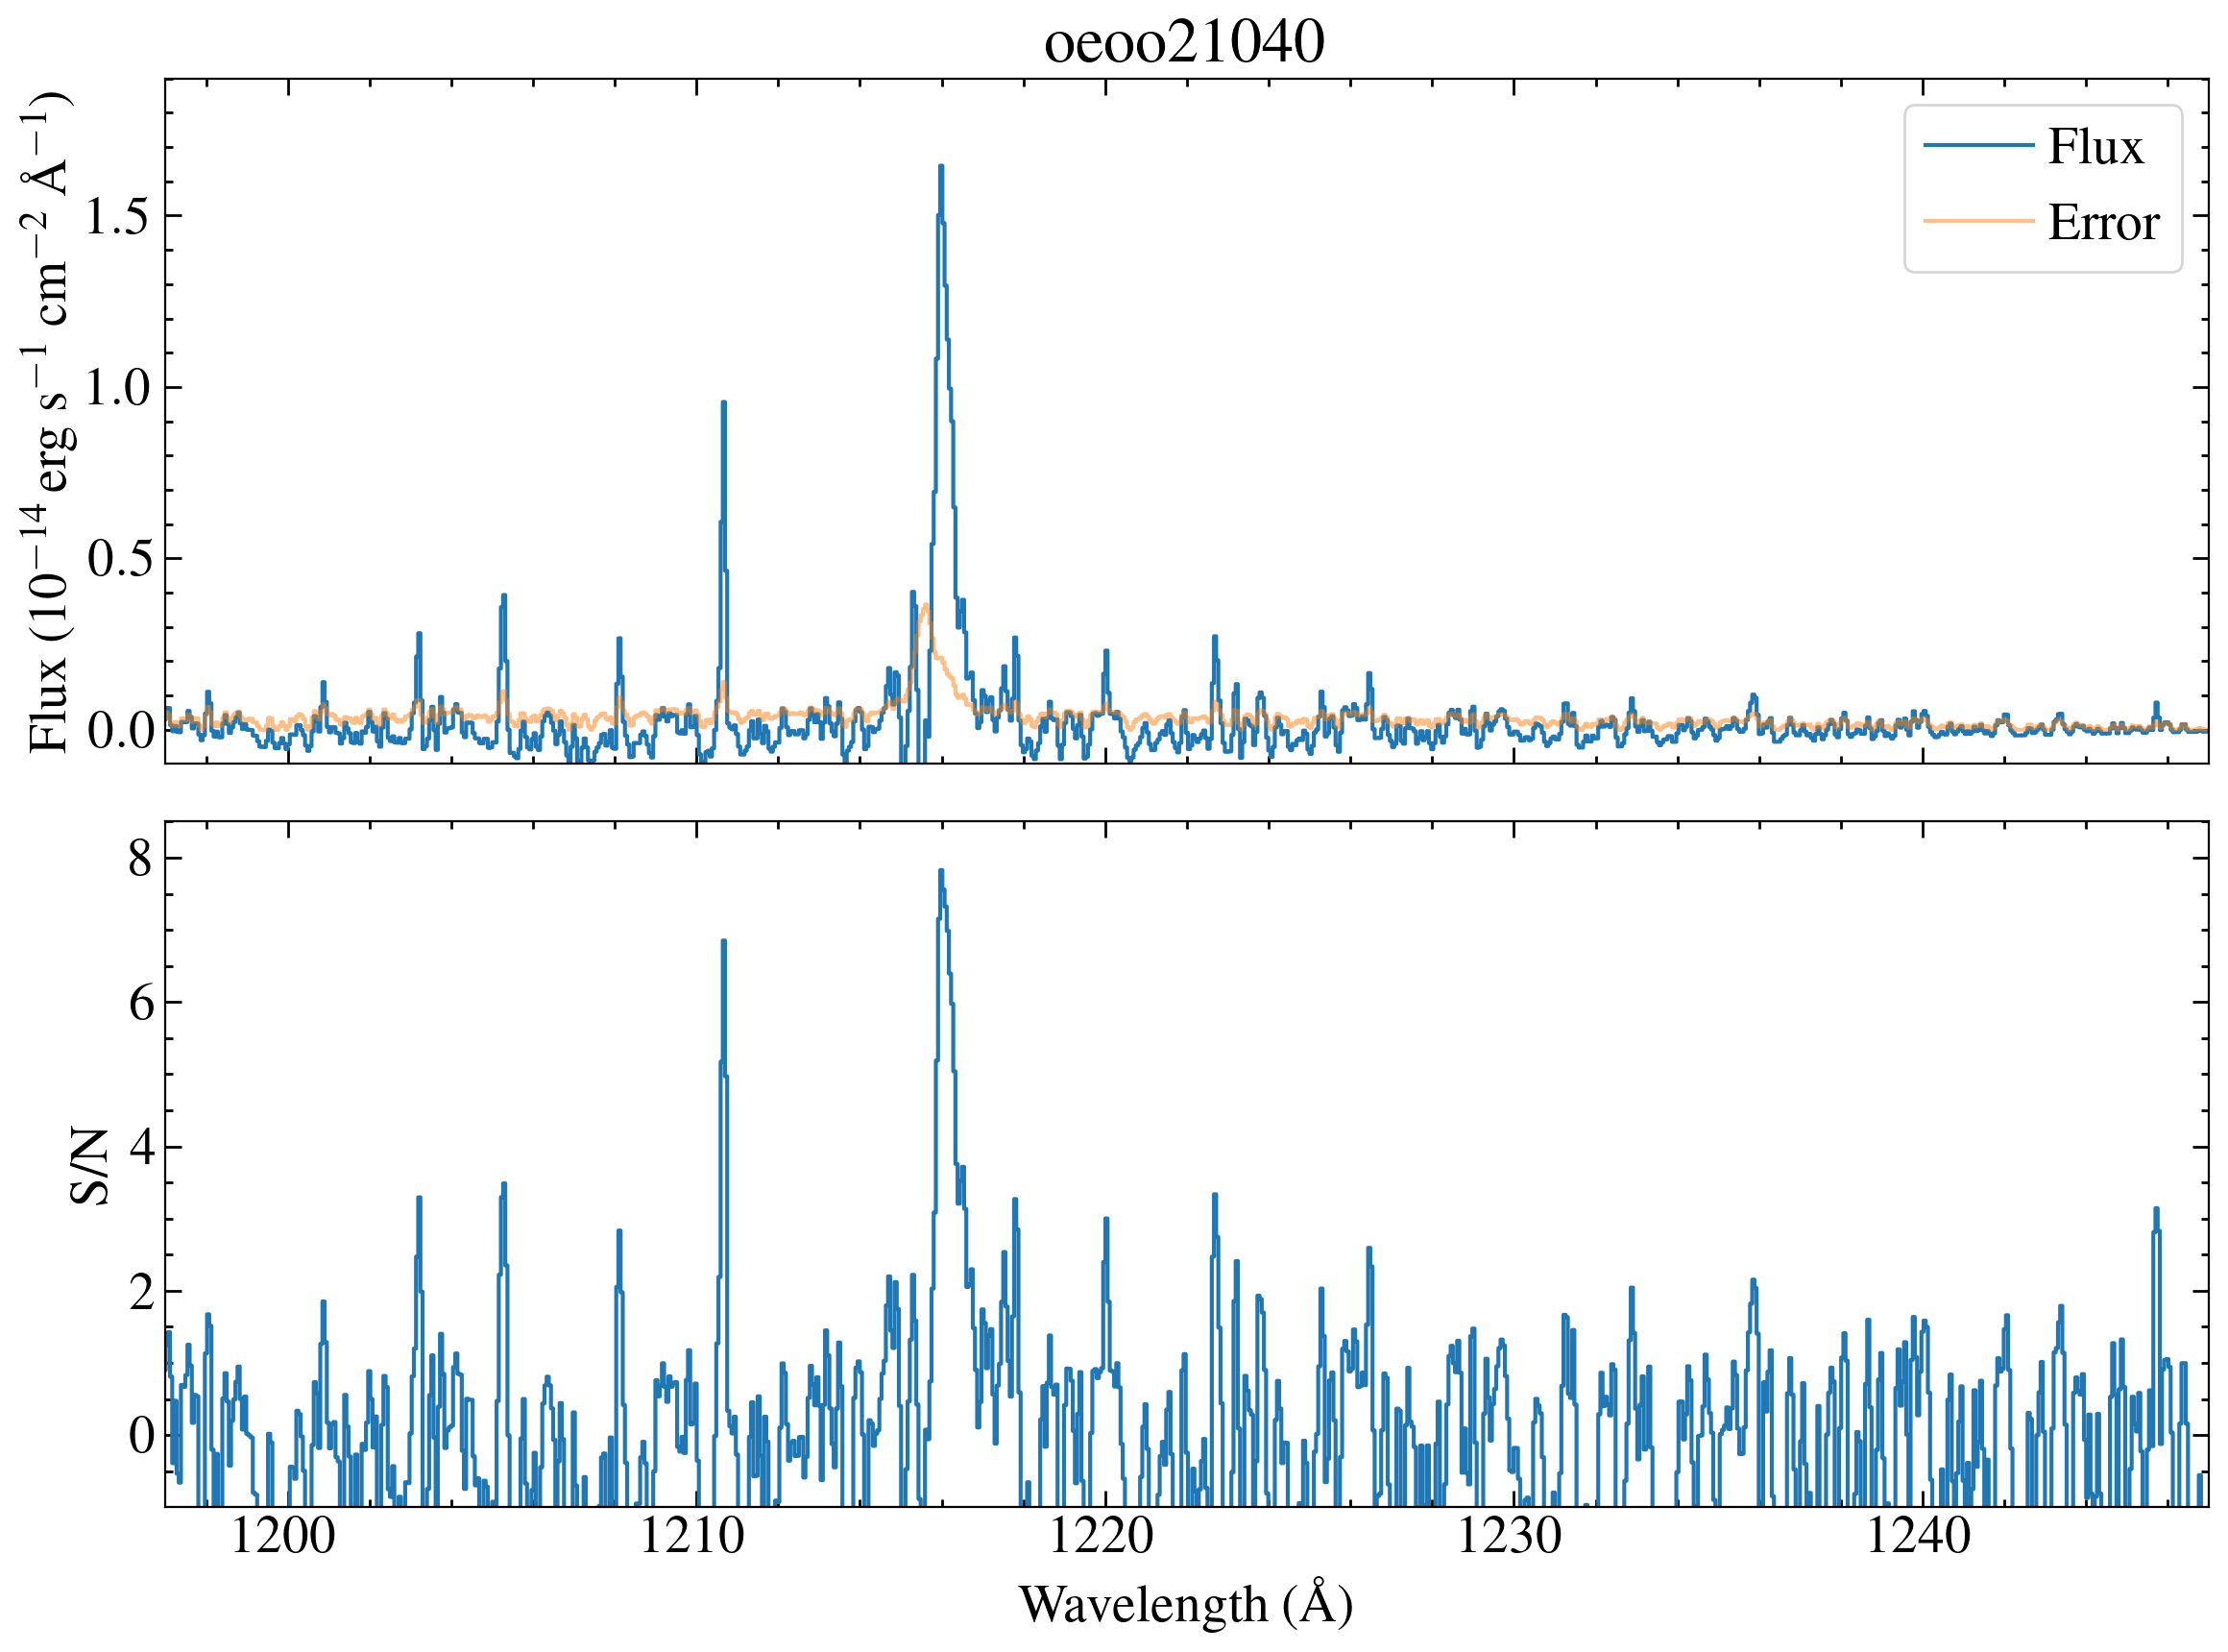

In [99]:
root = 'oeoo21040'

fig, axes = plt.subplots(figsize = (12, 9), nrows=2, ncols=1, sharex=True)
xs = [1197, 1247]
data = fits.getdata('reextractions/toi-178/{}_new_x1d.fits'.format(root), 1)[0]
print(data['A2Center'])
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

fi = convolve(f,  Box1DKernel(2))
ei = convolve(e,  Box1DKernel(2))/2**0.5

axes[0].step(w, fi*1e14, where='mid', label = 'Flux')
axes[0].step(w, ei*1e14, where='mid', alpha=0.5, label='Error')
axes[0].legend(frameon=True)
axes[0].set_ylabel('Flux (10$^{-14}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
axes[0].set_xlim(1197, 1247)
axes[0].set_ylim(-0.1, 1.9)
axes[0].set_title(root)


axes[1].step(w, fi/ei, where='mid')
# axes[1].step(w, f/e, where='mid')
axes[1].set_ylim(-1, 8.5)
axes[1].set_xlabel('Wavelength (\AA)')
axes[1].set_ylabel('S/N')

plt.tight_layout()
plt.savefig('plots/toi-178_{}_sn.png'.format(root), facecolor='w')
plt.savefig('plots/toi-178_{}_sn.pdf'.format(root))
# plt.show()


And again for visit 22. 

In [7]:
for root in  ['oeoo22010']:
    flt = '{}/{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/toi-178/{}_new_x1d.fits'.format(rootname)
    a2center = get_a2center(372, 109, tracegrid)
    print(a2center)
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/toi-178/{}_new.trl'.format(rootname), a2center=a2center, maxsrch=5)

111


109.91156


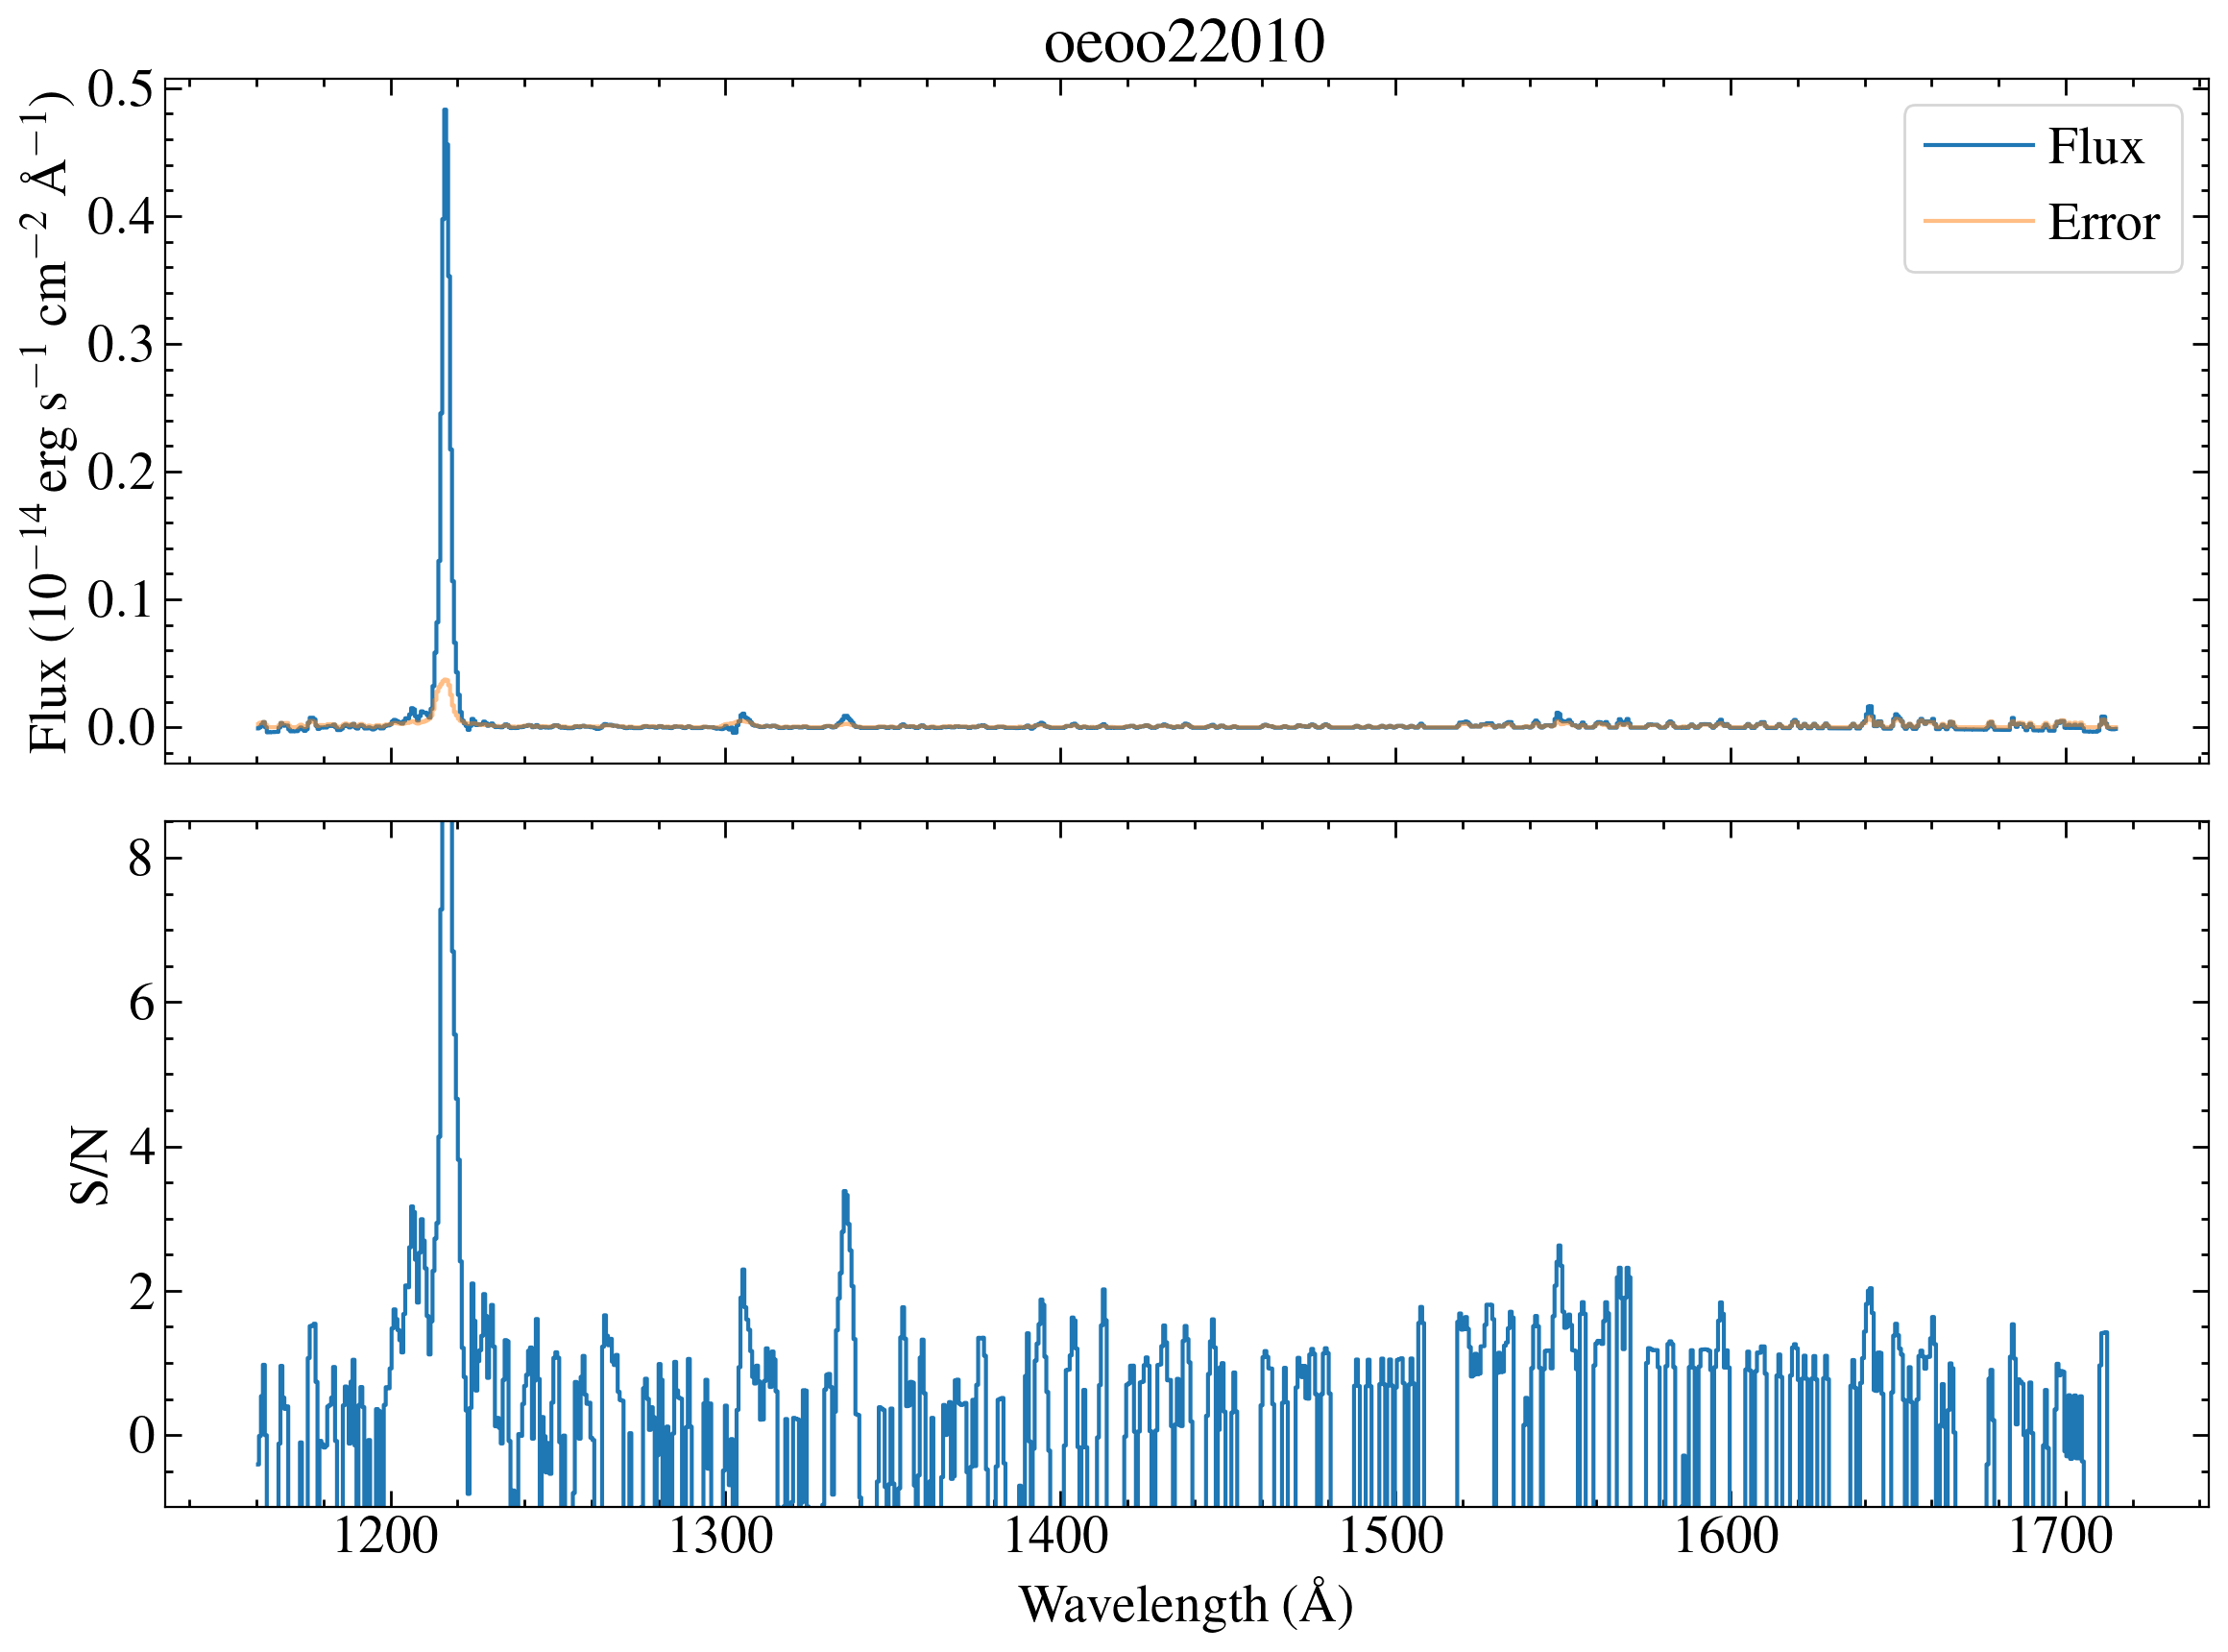

In [11]:
root = 'oeoo22010'

fig, axes = plt.subplots(figsize = (12, 9), nrows=2, ncols=1, sharex=True)
xs = [1197, 1247]
data = fits.getdata('reextractions/toi-178/{}_new_x1d.fits'.format(root), 1)[0]
print(data['A2Center'])
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = w > 1160
w, f, e = w[mask], f[mask], e[mask]


fi = convolve(f,  Box1DKernel(2))
ei = convolve(e,  Box1DKernel(2))/2**0.5

axes[0].step(w, fi*1e14, where='mid', label = 'Flux')
axes[0].step(w, ei*1e14, where='mid', alpha=0.5, label='Error')
axes[0].legend(frameon=True)
axes[0].set_ylabel('Flux (10$^{-14}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# axes[0].set_xlim(1197, 1247)
# axes[0].set_ylim(-0.1, 1.9)
axes[0].set_title(root)


axes[1].step(w, fi/ei, where='mid')
# axes[1].step(w, f/e, where='mid')
axes[1].set_ylim(-1, 8.5)
axes[1].set_xlabel('Wavelength (\AA)')
axes[1].set_ylabel('S/N')

plt.tight_layout()
# plt.savefig('plots/toi-178_{}_sn.png'.format(root), facecolor='w')
# plt.savefig('plots/toi-178_{}_sn.pdf'.format(root))
# plt.show()


109.91156


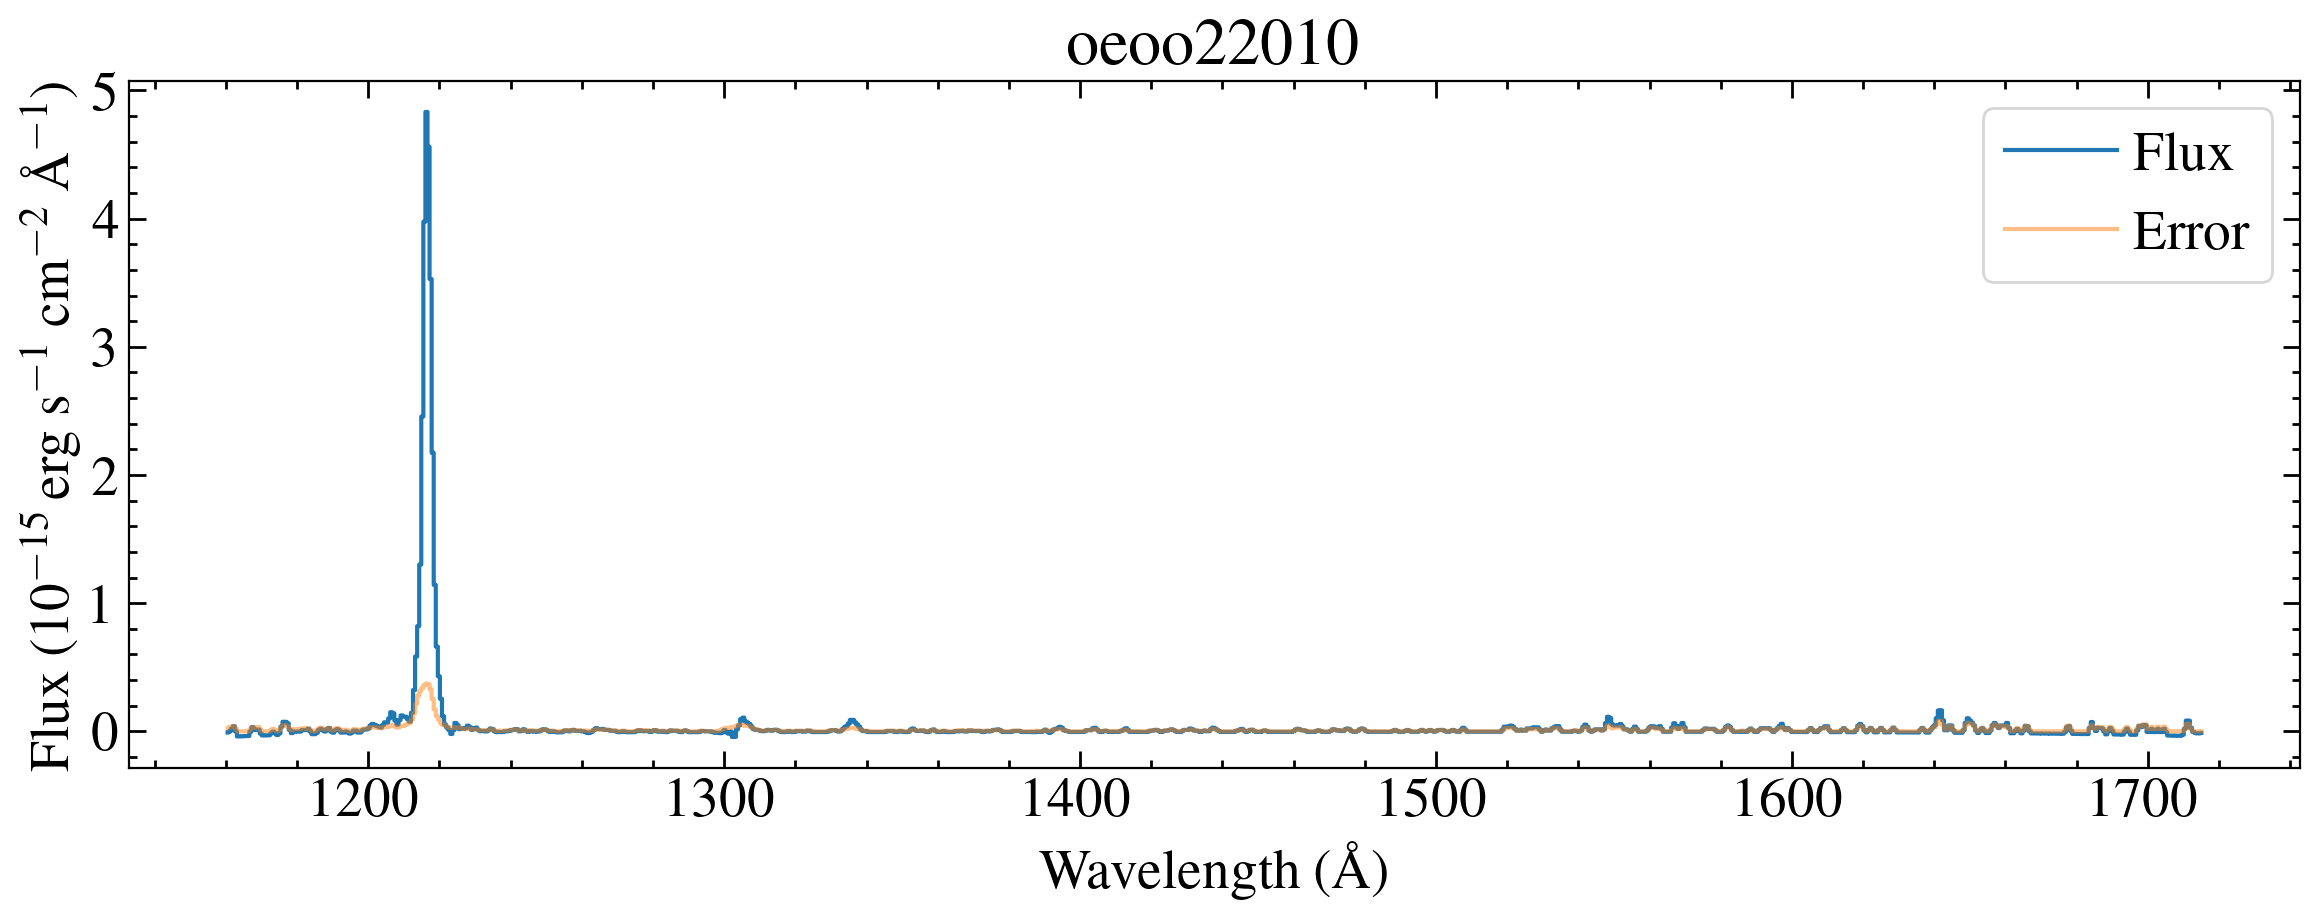

In [23]:
root = 'oeoo22010'

fig, axes = plt.subplots(figsize = (12, 5), nrows=1, ncols=1, sharex=True)
xs = [1197, 1247]
data = fits.getdata('reextractions/toi-178/{}_new_x1d.fits'.format(root), 1)[0]
print(data['A2Center'])
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = w > 1160
w, f, e = w[mask], f[mask], e[mask]


fi = convolve(f,  Box1DKernel(2))
ei = convolve(e,  Box1DKernel(2))/2**0.5
# fi = f
# ei = e

axes.step(w, fi*1e15, where='mid', label = 'Flux')
axes.step(w, ei*1e15, where='mid', alpha=0.5, label='Error')
axes.legend(frameon=True)
axes.set_ylabel('Flux (10$^{-15}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# axes[0].set_xlim(1197, 1247)
# axes.set_ylim(-0.1, 0.3)
axes.set_title(root)


# axes[1].step(w, fi/ei, where='mid')
# axes[1].step(w, f/e, where='mid')
# axes[1].set_ylim(-1, 8.5)
axes.set_xlabel('Wavelength (\AA)')
# axes[1].set_ylabel('S/N')

plt.tight_layout()
plt.savefig('plots/toi-178_{}.png'.format(root), facecolor='w')
plt.savefig('plots/toi-178_{}.pdf'.format(root))
# plt.show()
